## Toy 1D Interpolator
Simple 1D interpolator based off of Sections 3.1-3.2 in Numerical Analysis by Burden and Faires. Employs the Lagrange Polynomial method.

In [285]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [286]:
# define data table
x = np.array([1.0, 1.3, 1.6, 1.9, 2.2])
y = np.array([0.7651977, 0.6200860, 0.4554022, 0.2818186, 0.1103623])

# takes the x and y data arrays and ensures they are monotonically increasing
# this is important as bisection() only works for arrays like this
idx = np.argsort(x)
points = np.column_stack((x[idx], y[idx]))

The Lagrange Interpolating Polynomial is given by
$$
P_k(x) = \sum_{k = 0}^n f(x_k)L_{n,k}(x), \tag{3.1}
$$
where $k = 0,1,\dots,n,$
$$
L_{n,k}(x) = \prod_{\substack{i = 0 \\ i \neq k}}^n \frac{x - x_i}{x_k - x_i}. \tag{3.2}
$$

In [287]:
def _bisection(array, value) -> int:
    '''Given an ``array`` , and given a ``value`` , returns an index j such that ``value`` is between array[j]
    and array[j+1]. ``array`` must be monotonic increasing. j=-1 or j=len(array) is returned
    to indicate that ``value`` is out of range below and above respectively.
    
    Taken from https://stackoverflow.com/a/41856629'''
    n = len(array)
    if (value < array[0]):
        return -1
    elif (value > array[n-1]):
        return n
    jl = 0                          # Initialize lower
    ju = n-1                        # and upper limits.
    while (ju-jl > 1):              # If we are not yet done,
        jm=(ju+jl) >> 1             # compute a midpoint with a bitshift
        if (value >= array[jm]):
            jl=jm                   # and replace either the lower limit
        else:
            ju=jm                   # or the upper limit, as appropriate.
                                    # Repeat until the test condition is satisfied.
    if (value == array[0]):
        return 0
    elif (value == array[n-1]):# and top
        return n-1
    else:
        return jl

def _compute_lagrange_coeff(value, x_vals, k, i) -> float:
    # base case: the count is greater than number of terms
    if (i > len(x_vals)-1):
        return 1

    # recursive case 1: skip that part of the term if i = k
    if (i == k):
        return _compute_lagrange_coeff(value, x_vals, k, i+1)

    # recursive case 2: compute the term according to eq. 3.2
    return (value - x_vals[i])/(x_vals[k] - x_vals[i]) * _compute_lagrange_coeff(value, x_vals, k, i+1)

def Toy1DInterpolator(points: np.ndarray, value: float = 0.0, num_terms: int = 1) -> float:
    # If the user asks for far too many terms
    # aka more terms that points in input array
    if (num_terms > len(points[:,0])):
        raise RuntimeWarning("Number of requested terms exceeds number of points given.")

    # find the index of the closest x value to the value to be interpolated
    lower_index = _bisection(points[:,0], value)

    # edge case 1: requested x is lower than the lowest x value
    if (lower_index == -1):
        print("WARNING: Requested x is lower than lowest x in data.")
        lower_index = np.clip(lower_index, 0, None)

    # edge case 2: If the user asks for more terms but not enough close ones,
    # shift the index backward to get more data in
    # also handles requested x higher than the highest x value
    diff = len(points[lower_index:]) - num_terms
    if (diff < 0):
        # shift the index down
        lower_index += diff
        # cap it at zero
        lower_index = np.clip(lower_index, 0, None)

    # allocate arrays to hold x and f values needed
    x_vals = points[lower_index:lower_index+num_terms, 0]
    f_vals = points[lower_index:lower_index+num_terms, 1]

    # Debug Statements
    # print(f"clamped lindex: {lower_index} diff: {diff}")
    # print(f"x values: {x_vals}")
    # print(f"f values: {f_vals}")
    # for k in range(num_terms): # print number of terms
    #   print(f"term {k} -> {_compute_lagrange_coeff(value, x_vals, k, i=0)} x {f_vals[k]}")

    # evaluate eq. 3.1 at value requested
    sum = 0
    for k in range(num_terms):
        sum += _compute_lagrange_coeff(value, x_vals, k, i=0) * f_vals[k]

    return sum

In [288]:
print(f"{Toy1DInterpolator(points, 1.5, 5):0.7f}") # corresponds to P_4, as it is on page 118

0.5118200


## Test - Normal Distribution PDF

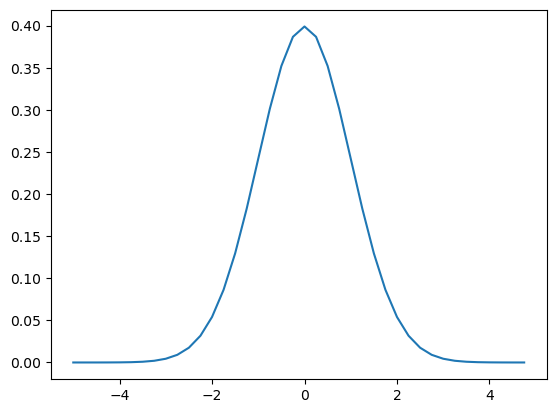

In [289]:
x = np.arange(-5, 5, 0.25)
y = stats.norm.pdf(x, loc=0, scale=1)

idx = np.argsort(x)
points = np.column_stack((x[idx], y[idx]))

plt.plot(x,y)

In [290]:
value = 0.125

interpolated = Toy1DInterpolator(points, value, 5)
actual = stats.norm.pdf(value, loc=0, scale=1)

print(f"Interpolated = {interpolated:0.7f}\n\
      Actual = {actual:0.7f}") # corresponds to P_4

perc_diff = np.abs(interpolated - actual) / actual * 100
print(f"Percent Difference = {perc_diff:0.2e}%")

Interpolated = 0.3958901
      Actual = 0.3958377
Percent Difference = 1.33e-02%
